In [35]:
from skimage import io
from skimage import transform
import numpy as np
import random
import math

# Funcion which creates array of puzzle pieces
# From a given picture

def from_image_to_pieces(image_path, n_rows, n_cols):
  
  image = io.imread(image_path)

  size = image.shape
  size = min(size[0], size[1])
  
  image = image[0:size, 0:size]

  step = math.floor(size / n_rows)
  
  pieces = []
  index = 0

  for i in range(n_rows):
    for j in range(n_cols):
      # Ovde je neophodno pamtiti par jer kad se radi shuffle te dve vrednosti moraju da ostanu zajedno
      pieces.append([np.array(image[i*step: (i+1)*step, j*step : (j+1)*step]), index])
      index += 1

  # pieces je lista listi pri cemu se svaka unutrasnja lista
  # sastoji od dva elementa gde je prvi deo slike, a drugi je
  # indeks dela u originalnoj slici 

  return pieces, step

pieces, step = from_image_to_pieces("lion.jpg", 5, 5)

In [36]:
def shuffle(pieces):
  random.shuffle(pieces)

  result = []
  rotations = []

  for x in pieces:
    (image, index) = x

    i = random.randint(0, 4)
    rotations.append(i)
    x = transform.rotate(image, i*90)
    result.append((x, index))

  return result, rotations

pieces, rotations = shuffle(pieces)

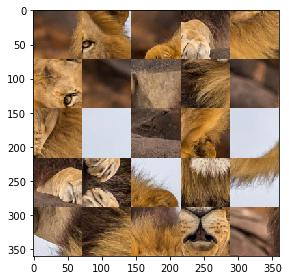

In [41]:
def make_image(pieces, step, n_rows, n_cols):

  image = np.array([])
  image = np.resize(image, (n_rows*step, n_cols*step, 3))

  for i in range(n_rows):
    for j in range(n_cols):
      piece, index = pieces[i*5+j]
      image[i*step : (i+1)*step, j*step : (j+1)*step] = piece
    
  io.imshow(image)
  io.imsave("slika.jpg", image)

  #return image
  
make_image(pieces, step, 5, 5)

In [38]:
class Chromosome:

  def __init__(self, genetic_code, fittness, rotations):
    self.fittness = fittness
    self.genetic_code = genetic_code
    self.rotations = rotations


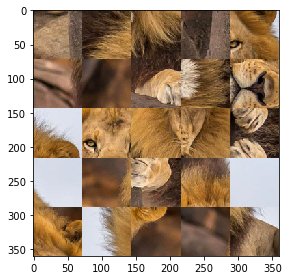

In [61]:
class GeneticAlgorithm:

  def __init__(self, image_path, n_rows):

    self.path = image_path                    # putanja do polazne slike
    self.n_rows = n_rows                      # broj redova u slagalici, u nasem slucaju ce broj kolona biti isti
    self.population_size = 100                # velicina populacije
    self.max_iteration = 300                  # broj iteracija algoritma
    self.tournament_size = 10                 # velicina jednog turnira u selekciji
    self.mutation_rate = 0.1                  # verovatnoca mutacije
    self.selection_type = 'tournament'        # tip selekcije
    self.selection_size = 100                 # velicina selekcije
    self.elite_size = 10                      # broj najboljih jedinki koje treba proslediti u narednu generaciju

  def get_diff(self, piece, ind, population):

    # piece je jedan deo slagalice, matrica size x size
    # population je lista listi od dva elementa, gde je prvi element deo slagalice,
    # a drugi indeks tog dela u polaznoj slagalici

    i = int(ind / 5)
    j = ind % 5

    #print(f"i: {i}, j: {j}")

    if i == 4 and j == 4:
      return 0

    if i == 4:
      next, index = population[ind+1]
      next_left_edge = next[:][0]

      piece_right_edge = piece[:][-1]


      #print("Piece right edge:")
      #print(piece_right_edge)

      #print("Next left edge:")
      #print(next_left_edge)

      result = 0

      for i in range(len(next_left_edge)):
        for j in range(3):
          result += next_left_edge[j] - piece_right_edge[j]

      return sum(result)

    if j == 4:
      next, index = population[ind+5]
      next_up_edge = next[0][:]

      piece_down_edge = piece[-1][:]

      result = 0

      for i in range(len(next_up_edge)):
        for j in range(3):
          result += abs(next_up_edge[j] - piece_down_edge[j])

      return sum(result)

    next_left, _ = population[ind+1]
    next_down, _ = population[ind+5]

    next_left_left_edge = next_left[:][0]
    next_down_up_edge = next_down[0][:]

    piece_right_edge = piece[:][-1]
    piece_down_edge = piece[-1][:]

    result = 0
    for i in range(len(next_down_up_edge)):
      for j in range(3):
        result += (next_left_left_edge[j] - piece_right_edge[j]) + (next_down_up_edge[j] - piece_down_edge[j])

    return sum(result)
 
  def calculate_fittness(self, genetic_code):

    fittness = 0
    # genetic_code je lista listi od dva elementa gde je prvi cela slagalica,
    # a drugi je pozicija tog dela u originalnoj slici

    for i in range(len(genetic_code)):
      piece, ind = genetic_code[i]
      fittness += self.get_diff(piece, i, genetic_code)**2

    #print("===========================================================")

    return fittness
            
    
  def init_population(self):

    population = []
    rotations = []
    init_puzzle, step = from_image_to_pieces(self.path, self.n_rows, self.n_rows)

    for i in range(self.population_size):
      result, rot = shuffle(init_puzzle)
      population.append(result)
      rotations.append(rot)

    new_pop = []

    for i in range(len(population)):
      x = population[i]
      rot = rotations[i]

      fittness = self.calculate_fittness(x)
      #print(fittness)
      new_pop.append(Chromosome(x, fittness, rot))

    return new_pop, step


  def selection(self, population, elite = False):

    # population je lista klasa Chromosome

    # we will think about this later
    # population = sorted(population, key=lambda x: x[0].fittness)

    selection = []
    if elite == True:
      if self.elite_size > self.selection_size:
        selection = population[0:selection_size]
        return selection
      else:
        selection = population[0:elite_size]

    if elite == True:
      for i in range(self.selection_size - self.elite_size):
        tourn = random.sample(population, self.tournament_size)
        selection.append(min(tourn, key=lambda x: x.fittness))
    else:
      for i in range(self.selection_size):
        tourn = random.sample(population, self.tournament_size)
        selection.append(min(tourn, key=lambda x: x.fittness))
  
    return selection

  def is_end(self, pieces):

    pieces = pieces.genetic_code

    for i in range(len(pieces)):
      x, index = pieces[i]
      if index != i:
        return False

    return True

  def cross(self, selection):
    return selection

  def mutation(self, selection):
    return selection

  def Optimize(self):

    population, step = self.init_population()

    global_best = Chromosome(None, math.inf, None)


    for i in range(self.max_iteration):

      selected = self.selection(population)

      population = self.cross(selected)
      population = self.mutation(selected)

      best = min(population, key=lambda x: x.fittness)

      if best.fittness < global_best.fittness:
        global_best = best

      if (self.is_end(best)):
        break

    return global_best, step

GA = GeneticAlgorithm("lion.jpg", 5)

best, step = GA.Optimize()

make_image(best.genetic_code, step, 5, 5)

